Features to include in visualization:

* Predict production by county and overall state (top level prediction)
* Can zoom into active sites (this may get laggy depending on how we handle data)
* Timelapse of when wells were developed. Have a slider that shows welsl for a selected year
    * Selection of top producing wells to show spatial evolution?
*  

Detailed description of proposed method (should be almost finished). Provide a clear list of innovations: give a list of the best 2-4 ideas that your approach exhibits.

25%] Detailed description of the design of upcoming experiments / evaluation

In [1]:
from sqlalchemy import create_engine, MetaData, or_, and_
from sqlalchemy import select, func 
from db_schema import OIL_PROD_TABLE, GAS_PROD_TABLE, LEASE_TABLE, WELLS_TABLE, TOPS_TABLE
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
engine = create_engine("sqlite:///../../kansas_oil_gas.db")
# Reflect oil production table
meta = MetaData()
meta.reflect(bind=engine)
oil_prod = meta.tables[OIL_PROD_TABLE]
gas_prod = meta.tables[GAS_PROD_TABLE]
lease = meta.tables[LEASE_TABLE]
wells = meta.tables[WELLS_TABLE]
tops = meta.tables[TOPS_TABLE]



In [3]:
kansas_prod = gpd.read_file("Shapefiles/OILGAS_FIELDS_GEO.shp")
kansas_poly = gpd.read_file("Shapefiles/kansas_poly.geojson")
#kansas_state = gpd.read_file("Shapefiles/tl_2017_20_cousub.shp")
kansas_state = gpd.read_file("Shapefiles/cb_2018_us_county_500k.shp")
kansas_state = kansas_state[kansas_state["STATEFP"]=='20'].reset_index(drop=True)

In [3]:
# Test cell
# s = select(
#     [
#         oil_prod.c.DATE,
#         func.sum(oil_prod.c.WELLS).label("N_WELLS"),
#         func.sum(oil_prod.c.PRODUCTION).label("MONTHLY_OIL_PROD"),
#     ]
# ).group_by(oil_prod.c.DATE)
# df_oil_prod = pd.read_sql(s, engine)

Check the relationship between number of wells to oil production. We should see a positive correlation with numbers of wells to production. 

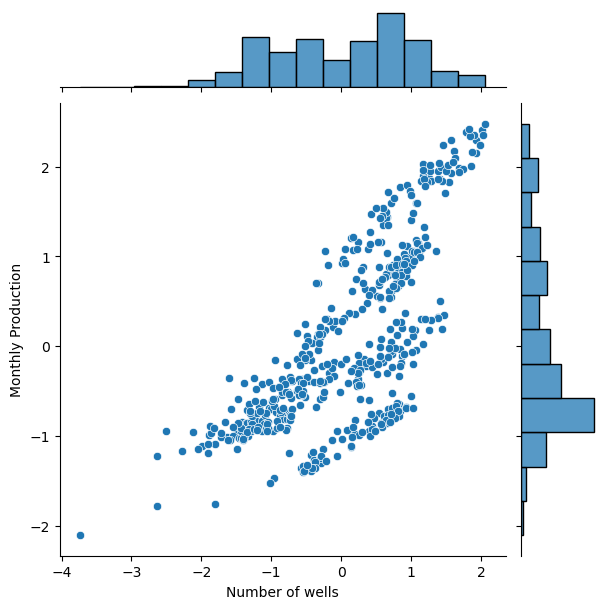

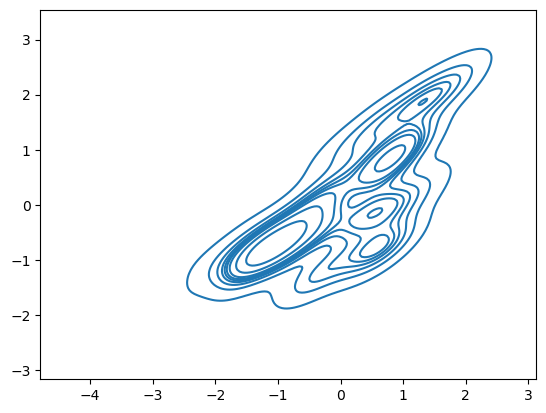

In [4]:
scale = StandardScaler()
nwells_scaled = scale.fit_transform(np.asarray(df_oil_prod["N_WELLS"])[:,None]).ravel()
oil_prod_scaled = scale.fit_transform(np.asarray(df_oil_prod["MONTHLY_OIL_PROD"])[:,None]).ravel()
sns.jointplot(x=nwells_scaled,y=oil_prod_scaled)
plt.xlabel("Number of wells")
plt.ylabel("Monthly Production")
plt.show()

sns.kdeplot(x=nwells_scaled,y=oil_prod_scaled)
plt.show()

There seems to be some clustering within the data as different sections of data seems to have a different relationship. Since these are time series, they might be seasonal effects, or technology effects (better technology throughout the years lead to increase in production from the same amount of wells), or even decom of new wells along with new wells giving the impression of increased production for the same number of wells.

Need to investigate how production varies in each lease? Maybe how lease start/end affects clustering? Geographic location?

Get Top production leases

In [12]:
s = select(
    [
        lease.c.COUNTY,
        lease.c.PRODUCES,
        lease.c.PRODUCTION,
        lease.c.YEAR_START,
        lease.c.YEAR_STOP,
        lease.c.LATITUDE,
        lease.c.LONGITUDE
    ]
).where(lease.c.PRODUCTION != None)
df_lease = pd.read_sql(s, engine)
geometry = [Point(xy) for xy in zip(df_lease['LONGITUDE'],df_lease['LATITUDE'])]
df_lease = gpd.GeoDataFrame(df_lease, geometry=geometry, crs = kansas_state.crs)

# Get production average per year for each lease to see which counties have the most prolific production
df_lease['year_span'] = (df_lease['YEAR_STOP'] - df_lease['YEAR_START']).apply(lambda x: max(x,1))
df_lease["yearly_production"] = df_lease['PRODUCTION'] / df_lease['year_span']

In [13]:
df_lease_gas = df_lease[df_lease['PRODUCES'] == 'GAS'].reset_index(drop=True)
df_lease_oil = df_lease[df_lease['PRODUCES'] == 'OIL'].reset_index(drop=True)

# Rank leases
tot_ranks = 100
df_lease_gas['rank'] = pd.Categorical(np.ceil(df_lease_gas['yearly_production'].rank(pct=True).mul(tot_ranks)).astype('Int64'))
df_lease_oil['rank'] = pd.Categorical(np.ceil(df_lease_oil['yearly_production'].rank(pct=True).mul(tot_ranks)).astype('Int64'))


Text(0.5, 1.0, 'Oil Production')

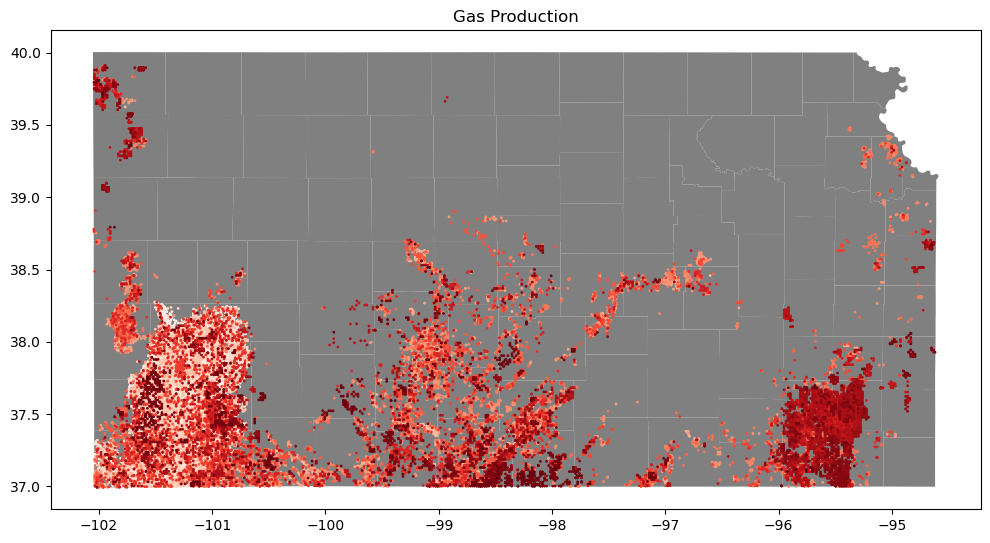

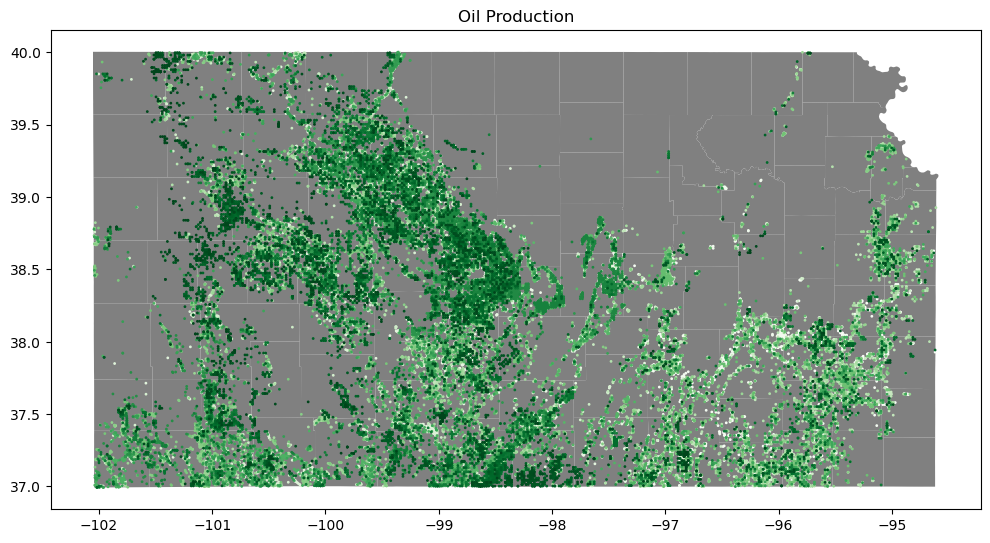

In [36]:
# Plot only Gas
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey')
df_lease_gas.plot(ax = ax, cmap = 'Reds', markersize = 1)
ax.set_title("Gas Production")

# Plot only Oil
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey')
df_lease_oil.plot(ax = ax, cmap = 'Greens', markersize = 1)
ax.set_title("Oil Production")


Determine Lease total production vs. Time series summation of production

In [148]:
s = select(
    [
        lease.c.LEASE_KID,
        lease.c.PRODUCES,
        lease.c.PRODUCTION
    ]
).where(lease.c.PRODUCTION != None)
df_total_production = pd.read_sql(s, engine)

s = select(
    [
        gas_prod.c.LEASE_KID,
        func.sum(gas_prod.c.PRODUCTION)
    ]
).group_by(gas_prod.c.LEASE_KID)
df_summed_gas_production = pd.read_sql(s, engine)

s = select(
    [
        oil_prod.c.LEASE_KID,
        func.sum(oil_prod.c.PRODUCTION)
    ]
).group_by(oil_prod.c.LEASE_KID)
df_summed_oil_production = pd.read_sql(s, engine)

# Merge into one df
df_total_production = df_total_production.merge(df_summed_gas_production, on="LEASE_KID", how="left") \
                            .rename(columns={"sum_1":"summed_gas"}).fillna(0)
df_total_production = df_total_production.merge(df_summed_oil_production, on="LEASE_KID", how="left") \
                            .rename(columns={"sum_1":"summed_oil"}).fillna(0)

df_total_production["Summations"] = df_total_production["summed_gas"] + df_total_production["summed_oil"]
df_total_production = df_total_production.drop(["summed_gas","summed_oil"], axis=1)


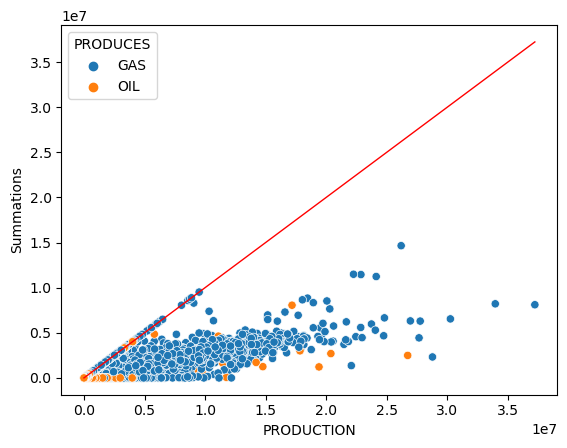

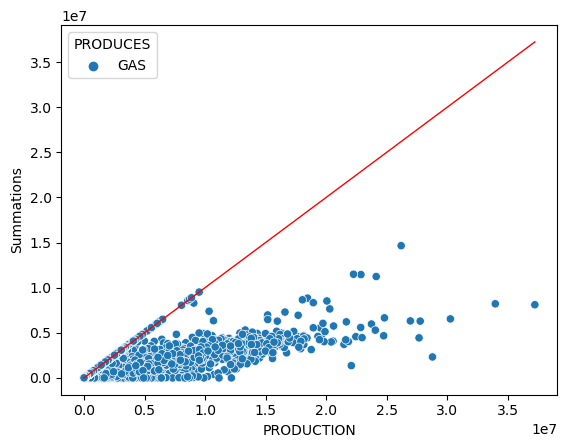

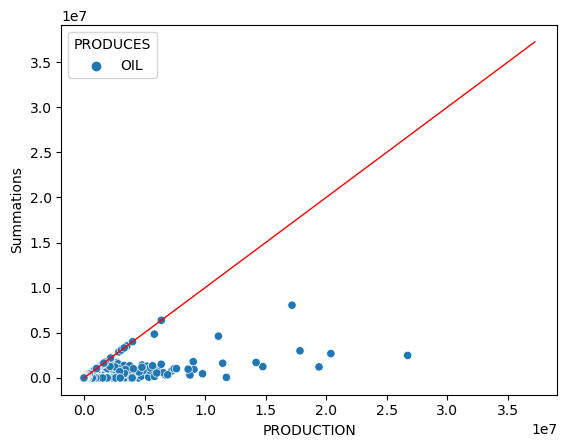

In [174]:
max_prod = max(df_total_production["PRODUCTION"].max(),df_total_production["Summations"].max())
sns.scatterplot(data=df_total_production, x='PRODUCTION', y='Summations', hue="PRODUCES")
X_plot = np.linspace(0, max_prod, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot,linewidth=1, color='red')
plt.show()

sns.scatterplot(data=df_total_production[df_total_production["PRODUCES"]=="GAS"], x='PRODUCTION', y='Summations', hue="PRODUCES")
X_plot = np.linspace(0, max_prod, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot,linewidth=1, color='red')
plt.show()

sns.scatterplot(data=df_total_production[df_total_production["PRODUCES"]=="OIL"], x='PRODUCTION', y='Summations', hue="PRODUCES")
X_plot = np.linspace(0, max_prod, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot,linewidth=1, color='red')
plt.show()

Detemine how many leases are active and how many are abandoned

In [7]:
s = select(
    [
        lease.c.LEASE_KID,
        lease.c.YEAR_START,
        lease.c.YEAR_STOP,
        lease.c.LATITUDE,
        lease.c.LONGITUDE
    ]
).where(lease.c.PRODUCTION != None)
df_active_leases = pd.read_sql(s, engine)
geometry = [Point(xy) for xy in zip(df_active_leases['LONGITUDE'],df_active_leases['LATITUDE'])]
df_active_leases = gpd.GeoDataFrame(df_active_leases, geometry=geometry, crs = kansas_state.crs)

df_active_leases["active"] = df_active_leases['YEAR_STOP'] == 2022
df_active_leases["years_active"] = (df_active_leases["YEAR_STOP"] - df_active_leases["YEAR_START"]).apply(lambda x: max(1,x))


In [8]:
print(df_active_leases["LEASE_KID"].count())
print(df_active_leases[df_active_leases["active"]==True]["LEASE_KID"].count())
print(df_active_leases[df_active_leases["active"]==False]["LEASE_KID"].count())

95329
31748
63581


Text(0.5, 1.0, 'Inactive Production')

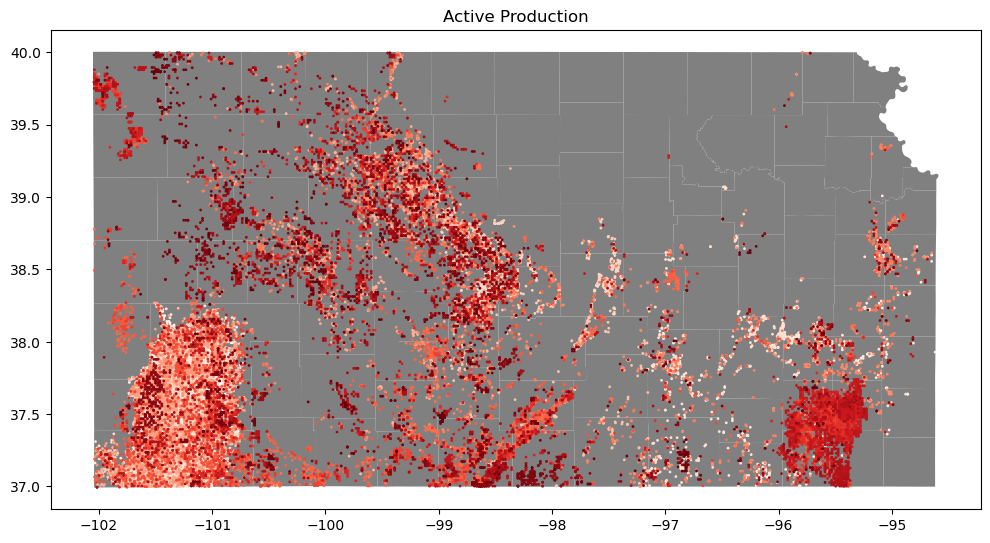

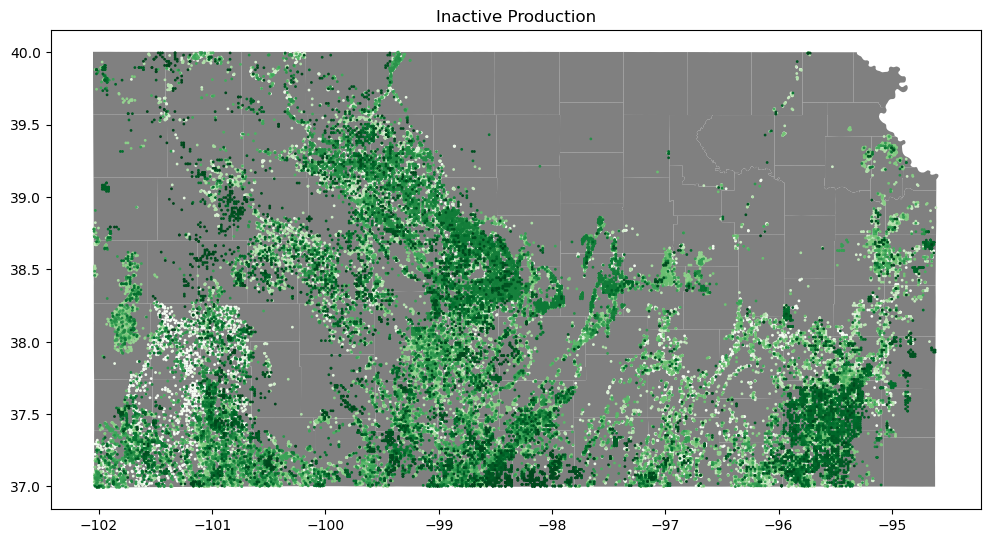

In [9]:
# Plot active leases
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey')
df_active_leases[df_active_leases["active"]==True].plot(ax = ax, cmap = 'Reds', markersize = 1)
ax.set_title("Active Production")

# Plot inactive leases
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey')
df_active_leases[df_active_leases["active"]==False].plot(ax = ax, cmap = 'Greens', markersize = 1)
ax.set_title("Inactive Production")


See which counties have the highest producing leases

In [14]:
kansas_counties = kansas_state[["NAME",'geometry']]

# Oil
top_oil_leases = df_lease_oil[df_lease_oil['rank'] == tot_ranks].reset_index(drop=True)
top_oil_leases = gpd.sjoin(top_oil_leases, kansas_counties, how="inner", predicate="intersects")

# Gas
top_gas_leases = df_lease_gas[df_lease_gas['rank'] == tot_ranks].reset_index(drop=True)
top_gas_leases = gpd.sjoin(top_gas_leases, kansas_counties, how="inner", predicate="intersects")

In [15]:
top_oil_leases

,COUNTY,PRODUCES,PRODUCTION,YEAR_START,YEAR_STOP,LATITUDE,LONGITUDE,geometry,year_span,yearly_production,rank,index_right,NAME
0,Butler,OIL,6712826.19,1965,2022,37.628510,-97.017094,POINT (-97.01709 37.62851),57,117768.880526,100,29,Butler
1,Butler,OIL,5066446.39,1965,2022,37.817444,-96.943676,POINT (-96.94368 37.81744),57,88885.024386,100,29,Butler
2,Butler,OIL,2740192.17,1965,1998,37.849215,-96.899845,POINT (-96.89984 37.84922),33,83036.126364,100,29,Butler
3,Butler,OIL,3826805.44,1965,2022,37.844637,-96.892920,POINT (-96.89292 37.84464),57,67136.937544,100,29,Butler
4,Butler,OIL,14767680.16,1965,2022,37.863600,-96.887289,POINT (-96.88729 37.86360),57,259082.108070,100,29,Butler
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,Gove,OIL,616668.14,2010,2022,38.880783,-100.806797,POINT (-100.80680 38.88078),12,51389.011667,100,23,Gove
515,Rush,OIL,478966.57,2010,2015,38.689305,-99.041786,POINT (-99.04179 38.68930),5,95793.314000,100,104,Rush
581,Lane,OIL,389803.53,2016,2022,38.474754,-100.530743,POINT (-100.53074 38.47475),6,64967.255000,100,22,Lane
584,Thomas,OIL,464445.66,2017,2022,39.183762,-100.971928,POINT (-100.97193 39.18376),5,92889.132000,100,57,Thomas


Top 1% of wells

Text(0.5, 1.0, 'Oil Production')

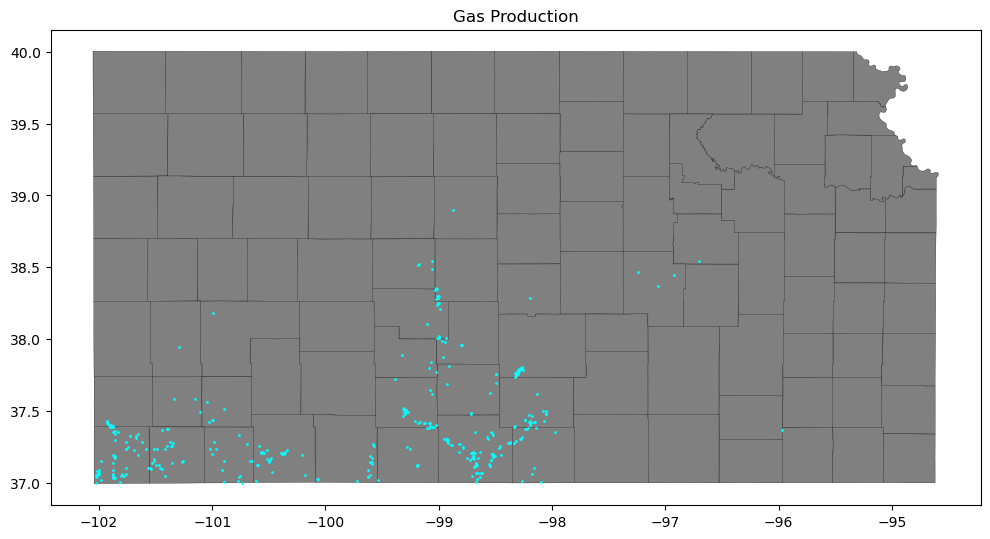

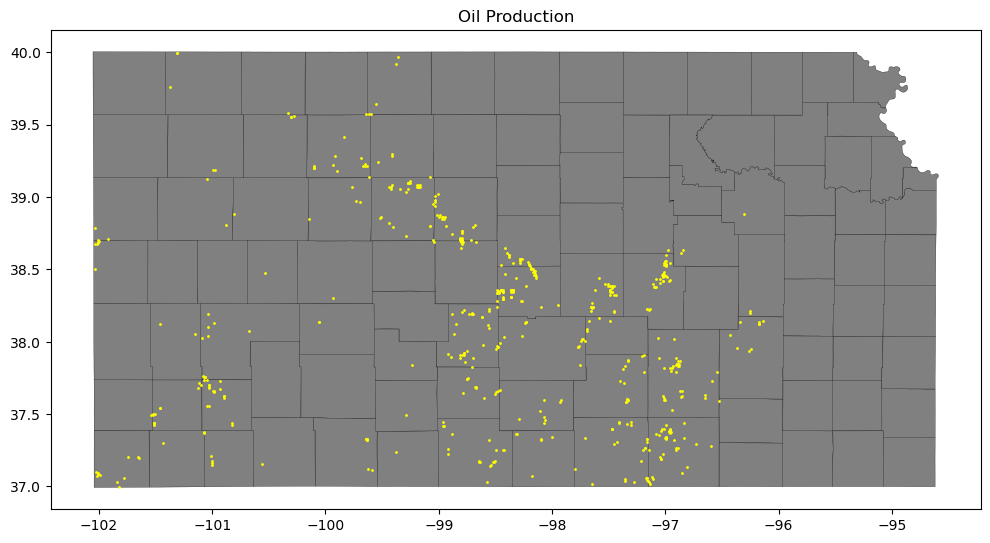

In [78]:
# Plot only Gas
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
top_gas_leases.plot(ax = ax, color = 'cyan', markersize = 1)
ax.set_title("Gas Production")

# Plot only Oil
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
top_oil_leases.plot(ax = ax, color = 'yellow', markersize = 1)
ax.set_title("Oil Production")

In [69]:
print(pd.unique(kansas_state['NAME']).size)
print(pd.unique(top_oil_leases['NAME']).size)
print(pd.unique(top_gas_leases['NAME']).size)


105
53
27


Get leases development as years progresses

In [282]:
s = select(func.min(lease.c.YEAR_START), func.max(lease.c.YEAR_START), func.min(lease.c.YEAR_STOP), func.max(lease.c.YEAR_STOP))
years = np.array(pd.read_sql(s, engine))
years = np.arange(years.min(), years.max())

def get_specific_year(year):
    s = select(
            [
                lease.c.LEASE_KID,
                lease.c.PRODUCES,
                lease.c.YEAR_START,
                lease.c.YEAR_STOP,
                lease.c.LATITUDE,
                lease.c.LONGITUDE

            ]
        ).where(and_(lease.c.PRODUCTION != None, int(year) >= lease.c.YEAR_START, int(year) <= lease.c.YEAR_STOP))
    return pd.read_sql(s, engine)


<AxesSubplot: >

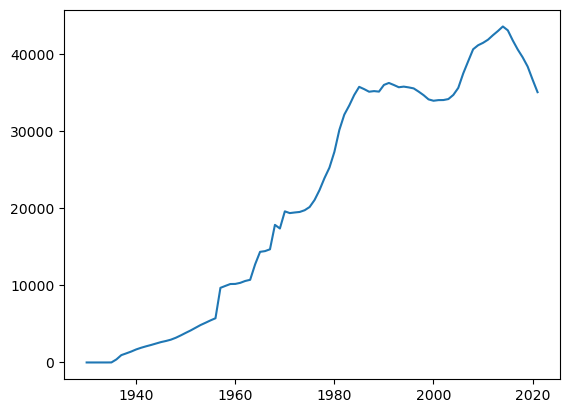

In [283]:
num_leases = []
for year in years:
   num_leases.append(get_specific_year(year)["LEASE_KID"].count())
sns.lineplot(x=years, y=num_leases)

Text(0.5, 1.0, 'Leases in given year')

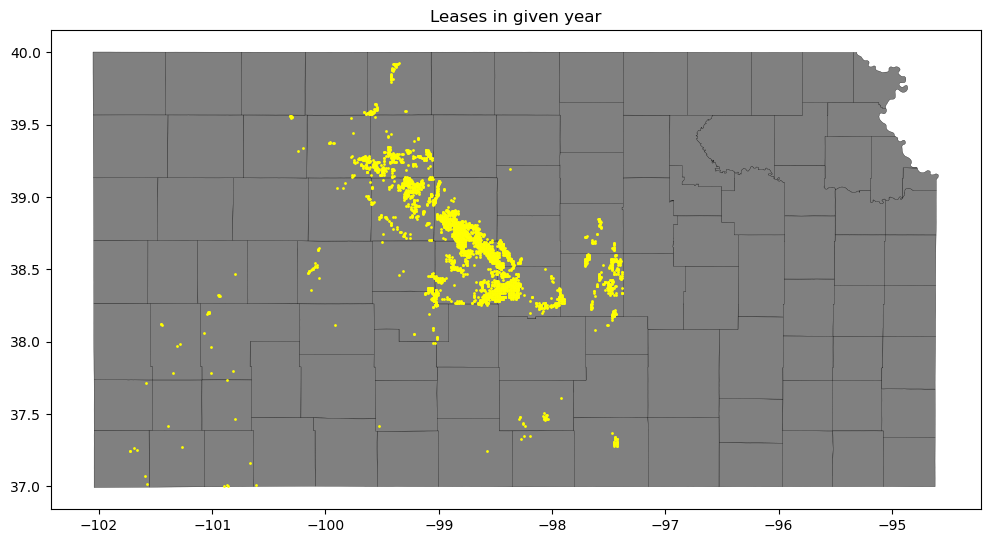

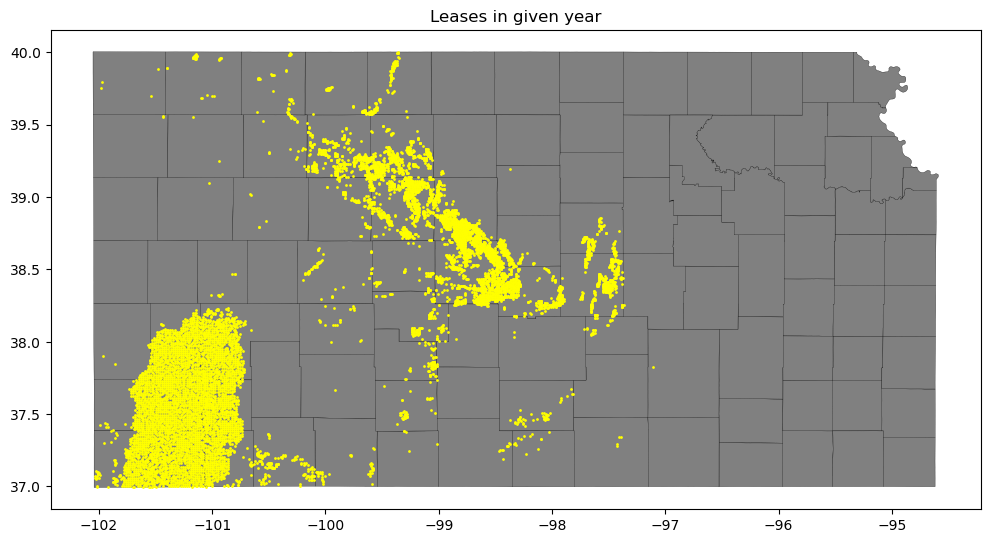

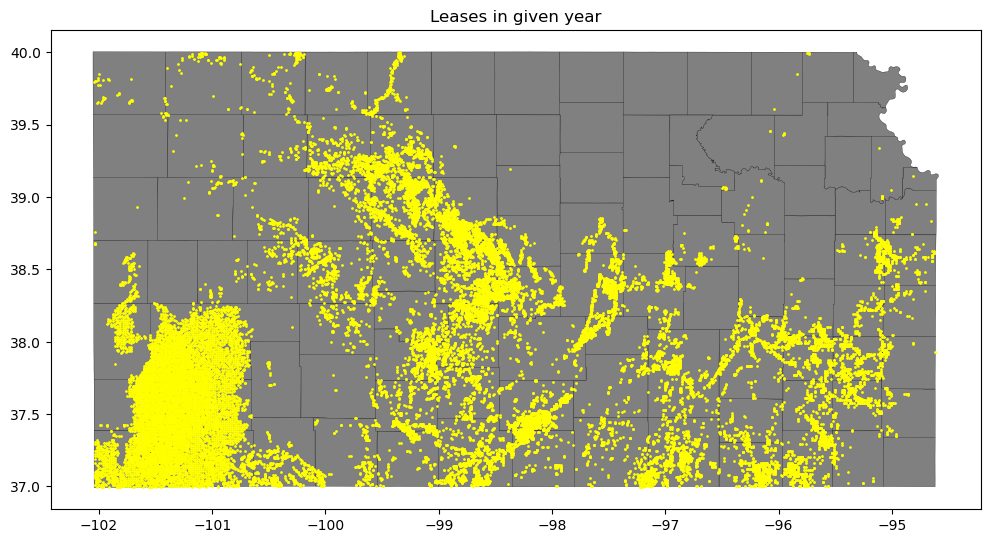

In [291]:
df_leases = get_specific_year(1950)
geometry = [Point(xy) for xy in zip(df_leases['LONGITUDE'],df_leases['LATITUDE'])]
df_leases = gpd.GeoDataFrame(df_leases, geometry=geometry, crs = kansas_state.crs)

# Plot leases in given year
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
df_leases.plot(ax = ax, color = 'yellow', markersize = 1)
ax.set_title("Leases in given year")

####

df_leases = get_specific_year(1960)
geometry = [Point(xy) for xy in zip(df_leases['LONGITUDE'],df_leases['LATITUDE'])]
df_leases = gpd.GeoDataFrame(df_leases, geometry=geometry, crs = kansas_state.crs)

# Plot leases in given year
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
df_leases.plot(ax = ax, color = 'yellow', markersize = 1)
ax.set_title("Leases in given year")

####

df_leases = get_specific_year(1980)
geometry = [Point(xy) for xy in zip(df_leases['LONGITUDE'],df_leases['LATITUDE'])]
df_leases = gpd.GeoDataFrame(df_leases, geometry=geometry, crs = kansas_state.crs)

# Plot leases in given year
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
df_leases.plot(ax = ax, color = 'yellow', markersize = 1)
ax.set_title("Leases in given year")



Get lease data by Counties

In [4]:
s = select(
    [
        lease.c.LEASE_KID,
        lease.c.LATITUDE,
        lease.c.LONGITUDE,
        lease.c.PRODUCES

    ]
).where(lease.c.PRODUCTION != None)
df_leases = pd.read_sql(s, engine)
geometry = [Point(xy) for xy in zip(df_leases['LONGITUDE'],df_leases['LATITUDE'])]
df_leases = gpd.GeoDataFrame(df_leases, geometry=geometry, crs = kansas_state.crs)

s = select(
    [
        gas_prod.c.LEASE_KID,
        gas_prod.c.DATE,
        gas_prod.c.WELLS,
        gas_prod.c.PRODUCTION

    ]
)
df_gas_prods = pd.read_sql(s, engine)

s = select(
    [
        oil_prod.c.LEASE_KID,
        oil_prod.c.DATE,
        oil_prod.c.WELLS,
        oil_prod.c.PRODUCTION
    ]
)
df_oil_prods = pd.read_sql(s, engine)


Text(0.5, 1.0, 'Oil Leases year')

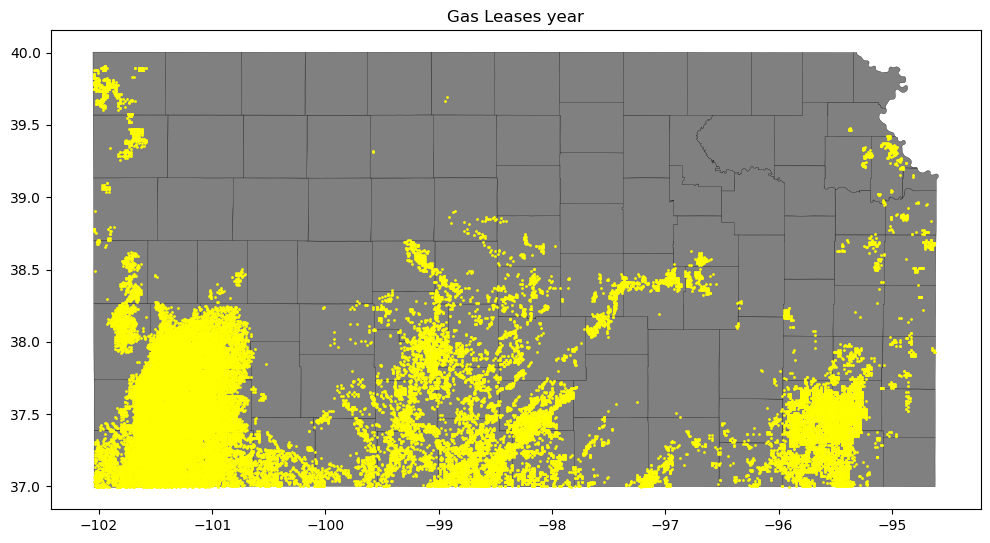

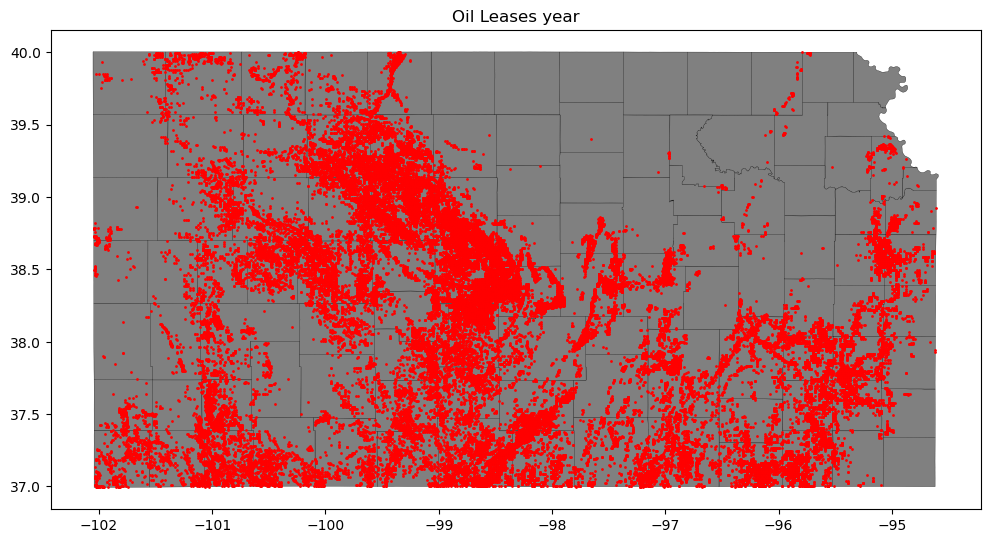

In [5]:
kansas_counties = kansas_state[["NAME",'geometry']]

# Plot leases in given year
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
df_leases[df_leases["PRODUCES"]=="GAS"].plot(ax = ax, color = 'yellow', markersize = 1)
ax.set_title("Gas Leases year")

# Plot leases in given year
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
df_leases[df_leases["PRODUCES"]=="OIL"].plot(ax = ax, color = 'red', markersize = 1)
ax.set_title("Oil Leases year")

In [9]:
leases_by_county = gpd.sjoin(df_leases, kansas_counties, how="inner", predicate="intersects")
leases_by_county = leases_by_county[["LEASE_KID","PRODUCES","geometry","NAME"]]
leases_by_county

,LEASE_KID,PRODUCES,geometry,NAME
0,1001103040,GAS,POINT (-100.98399 37.10606),Seward
1,1001103041,GAS,POINT (-100.94979 37.13444),Seward
44,1001103084,GAS,POINT (-100.95061 37.35117),Seward
45,1001103085,GAS,POINT (-100.93234 37.12048),Seward
46,1001103086,GAS,POINT (-100.93139 37.13399),Seward
...,...,...,...,...
80584,1037493102,OIL,POINT (-96.97023 39.28542),Clay
84390,1041035251,OIL,POINT (-96.97036 39.27091),Clay
65684,1020036310,OIL,POINT (-97.65693 39.40122),Cloud
76656,1033971875,GAS,POINT (-98.92531 39.69099),Smith


In [10]:
df_gas_merged = pd.merge(leases_by_county, df_gas_prods, on="LEASE_KID", how="right")
df_oil_merged = pd.merge(leases_by_county, df_oil_prods, on="LEASE_KID", how="right")

In [12]:
df_gas_merged.to_csv("gas_by_county.csv")
df_oil_merged.to_csv("oil_by_county.csv")

Text(0.5, 1.0, 'Oil - Seward County Leases')

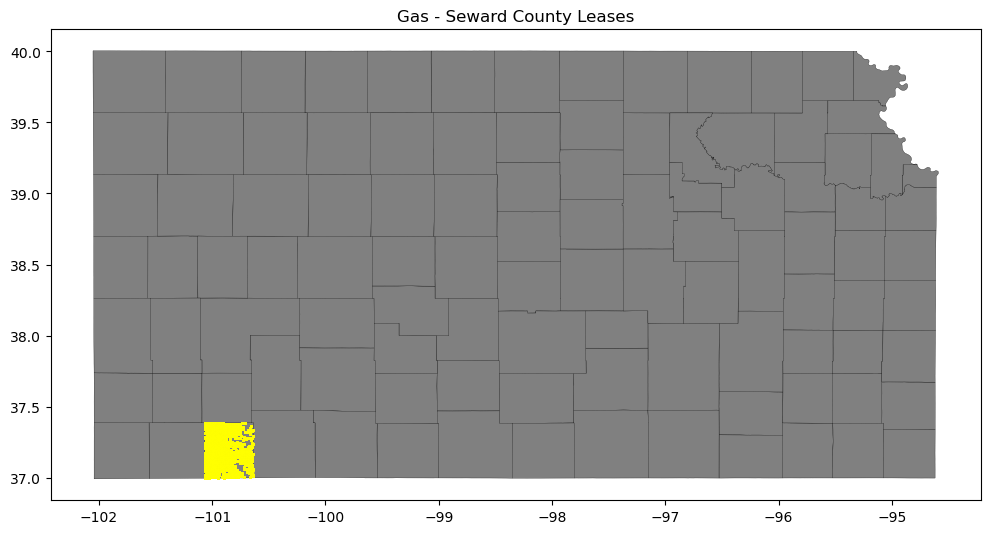

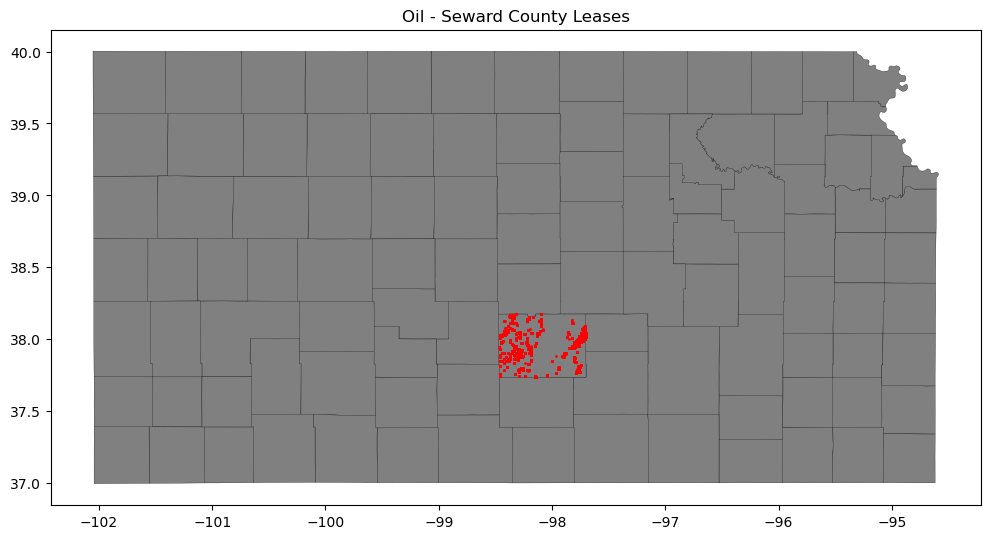

In [13]:
# Plot gas leases in given year
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
df_gas_merged[df_gas_merged["NAME"] == "Seward"].plot(ax = ax, color = 'yellow', markersize = 1)
ax.set_title("Gas - Seward County Leases")


# Plot oil leases in given year
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
df_oil_merged[df_oil_merged["NAME"] == "Reno"].plot(ax = ax, color = 'red', markersize = 1)
ax.set_title("Oil - Seward County Leases")